In [ ]:
# Esse módulo fará a leitura dos arquivos Amostragem de acordo com as datas
# dois dias anteriores para fazer a previsão data quando TODOS estarão vacinados!

In [2]:
import csv
import time
import requests 
import pandas  as pd
import seaborn as sns
from random   import random
from datetime import datetime

# Importar bibliotecas para construir gráficos:

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Bibliotecas de Algoritmos de Regressão:
from sklearn.tree            import DecisionTreeClassifier
from catboost                import CatBoostClassifier
from sklearn.metrics         import accuracy_score
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing   import StandardScaler
from sklearn.ensemble        import RandomForestRegressor, ExtraTreesRegressor

sns.set()

# Leitura do arquivo de Vacinacao completo selecionando alguns
# campos para pesquisa:

# Leitura BD_Amostra do dia 06/05/2021:
# Amostra_antes ==> DataFrame com data anterior

print('Fazendo as leituras dos Arquivos csv ....')

Amostra_antes = pd.read_csv("BD_Amostra-Alguns-06-05-2021.csv", sep=";")
usecols   = ['vacina_fabricante_nome',
                 'paciente_idade',
                 'paciente_id',
                 'vacina_dataAplicacao',
                 'paciente_endereco_uf',
                 'vacina_descricao_dose']

# Leitura do segundo Amostra para comparacao: 08/05/2021:
# Amostra_atual ==> DataFrame com data mais recente

Amostra_atual = pd.read_csv("BD_Amostra-Alguns-08-05-2021.csv", sep=";")
usecols   = ['vacina_fabricante_nome',
                 'paciente_idade',
                 'paciente_id',
                 'vacina_dataAplicacao',
                 'paciente_endereco_uf',
                 'vacina_descricao_dose']



Fazendo as leituras dos Arquivos csv ....


In [ ]:
# Preciso tratar a data para fazer previsão: 

# Modulo: Tratando=Data-Grafico

# Preparando o campo "vacina_dataAplicacao com Data anterior:
# para o datetime: formato = "%Y/%m/%d"

In [3]:
Amostra_antes['vacina_dataAplicacao'] = pd.to_datetime(Amostra_antes['vacina_dataAplicacao'], 
      format = "%Y-%m-%dT%H:%M:%S")

Amostra_atual['vacina_dataAplicacao'] = pd.to_datetime(Amostra_atual['vacina_dataAplicacao'], 
      format = "%Y-%m-%dT%H:%M:%S")

In [ ]:
#Criar uma coluna com Número 1, apenas para contar o total de cada vacina
# para ter dados acumulativos

In [4]:
Amostra_antes["counter"] = Amostra_atual["counter"] = 1

In [ ]:
# Criar o Pivot Tsble para acumulado dos dias:

In [6]:
# Pivot Test ANTES

pivot_test_antes= pd.pivot_table(Amostra_antes, 
                            index   = "vacina_dataAplicacao", 
                            columns = 'vacina_fabricante_nome',
                            values  = "counter",
                            aggfunc = "sum",
                            fill_value=0)
pivot_test_antes= pivot_test_antes.reset_index()


# Pivot Test ATUAL:
pivot_test_atual= pd.pivot_table(Amostra_atual, 
                            index   = "vacina_dataAplicacao", 
                            columns = 'vacina_fabricante_nome',
                            values  = "counter",
                            aggfunc = "sum",
                            fill_value=0)
pivot_test_atual= pivot_test_atual.reset_index()




In [ ]:
# Pivot test será criado para ter o total de vacinados entre 
## 19/01/2021 e 01/05/2021

In [7]:
# Pivot Test ANTES:

pivot_test_antes = pivot_test_antes.loc[(pivot_test_antes["vacina_dataAplicacao"]>="2021-01-01") &
            (pivot_test_antes["vacina_dataAplicacao"]<"2021-05-01")].reset_index(drop=True)

# Pivot Test ATUAL:

pivot_test_atual = pivot_test_atual.loc[(pivot_test_atual["vacina_dataAplicacao"]>="2021-01-01") &
            (pivot_test_atual["vacina_dataAplicacao"]<"2021-05-01")].reset_index(drop=True)

In [8]:
for vacina_fabricante_nome in pivot_test_antes.columns[1:]:
    pivot_test_antes[f"{vacina_fabricante_nome}_acumulado"] = pivot_test_antes[vacina_fabricante_nome].cumsum()
    

# Modulo: Primeira-Segunda-Dose

# Tratando o campo "vacina_dataAplicacao"  para verificar a data de
# aplicação da Vacina Primeira Dose e se após um tempo tomou a 
# Segunda Dose:

In [10]:
Amostra_antes["vacina_descricao_dose"].unique()


array(['\xa0\xa0\xa0\xa01ª\xa0Dose', '\xa0\xa0\xa0\xa02ª\xa0Dose'],
      dtype=object)

In [11]:
Amostra_atual["vacina_descricao_dose"].unique()

array(['\xa0\xa0\xa0\xa01ª\xa0Dose', '\xa0\xa0\xa0\xa02ª\xa0Dose'],
      dtype=object)

In [12]:
# Fazendo uma limpeza do campo "vacina_descricao_dose" para 
# os dois DataFrames:

# 1) Transformando todos as linhas como Minuúsculas
# 2) Quando aparecer Null (NaN) substitui-se por "-"
# 3) Tratando todos os caracteres ASCII 

Amostra_antes["vacina_descricao_dose"] = (Amostra_antes["vacina_descricao_dose"]
                                 .str.lower()
                                 .str.normalize("NFKD")
                                 .str.lstrip()
                                 .str.replace(" ","_")
                                 .str.encode("ascii", errors="ignore")
                                 .str.decode("utf-8"))


Amostra_atual["vacina_descricao_dose"] = (Amostra_atual["vacina_descricao_dose"]
                                 .str.lower()
                                 .str.normalize("NFKD")
                                 .str.lstrip()
                                 .str.replace(" ","_")
                                 .str.encode("ascii", errors="ignore")
                                 .str.decode("utf-8"))


In [10]:
Amostra_antes["vacina_descricao_dose"].value_counts

<bound method IndexOpsMixin.value_counts of 0        1a_dose
1        1a_dose
2        2a_dose
3        1a_dose
4        2a_dose
          ...   
47645    1a_dose
47646    2a_dose
47647    1a_dose
47648    1a_dose
47649    1a_dose
Name: vacina_descricao_dose, Length: 47650, dtype: object>

In [19]:
Amostra_atual["vacina_descricao_dose"].value_counts

<bound method IndexOpsMixin.value_counts of 0        1a_dose
1        2a_dose
2        1a_dose
3        1a_dose
4        1a_dose
          ...   
48659    1a_dose
48660    1a_dose
48661    1a_dose
48662    2a_dose
48663    1a_dose
Name: vacina_descricao_dose, Length: 48664, dtype: object>

<AxesSubplot:xlabel='vacina_descricao_dose', ylabel='count'>

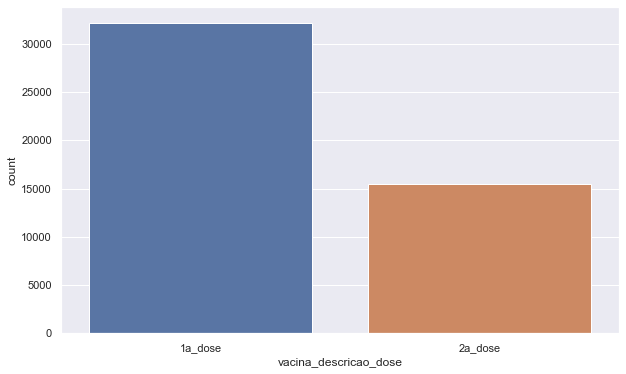

In [13]:
plt.figure(figsize = (10,6))
sns.countplot(data = Amostra_antes, x = "vacina_descricao_dose")

Text(0, 0.5, 'Contagem')

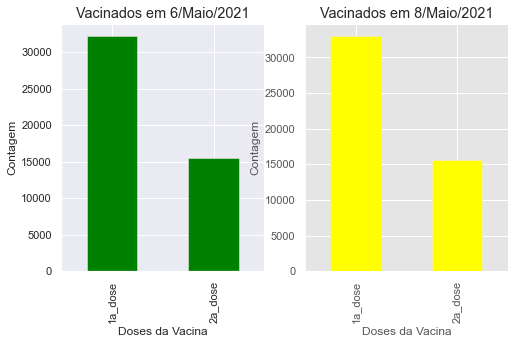

In [15]:
# Dois gráficos comparacao:

fig = plt.figure(figsize = (8, 10))

# Divide a figura em dois gráficos: lado esquerdo ==> Doses Antes:

ax1 = fig.add_subplot(2,2,1)
plt.style.use("ggplot")

#Amostra_antes["vacina_descricao_dose"].hist(bins = 20, ec = "k", alpha = .6, color = "red")

Amostra_antes['vacina_descricao_dose'].value_counts().plot(kind = 'bar', color = 'green') 
plt.title("Vacinados em 6/Maio/2021")
plt.xlabel("Doses da Vacina")
plt.ylabel("Contagem")


# Divide a figura em dois gráficos: lado direito ==> Doses Atual:
ax2 = fig.add_subplot(2,2,2)
plt.style.use("ggplot")

# Amostra_atual["vacina_descricao_dose"].hist(bins = 20, ec = "k", alpha = .6, color = "blue")

Amostra_atual['vacina_descricao_dose'].value_counts().plot(kind = 'bar', color = 'yellow') 
plt.title("Vacinados em 8/Maio/2021")
plt.xlabel("Doses da Vacina")
plt.ylabel("Contagem")




<AxesSubplot:xlabel='count', ylabel='vacina_descricao_dose'>

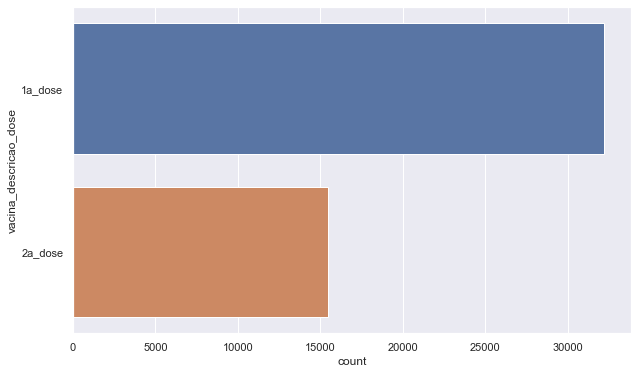

In [14]:
# Momento Antes:

plt.figure(figsize = (10,6))
sns.countplot(data=Amostra_antes, y = "vacina_descricao_dose")

<AxesSubplot:xlabel='count', ylabel='vacina_descricao_dose'>

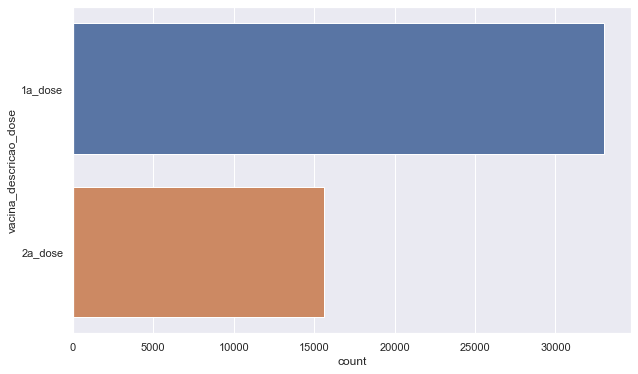

In [40]:
# Momento Atual:

plt.figure(figsize = (10,6))
sns.countplot(data=Amostra_atual, y = "vacina_descricao_dose")

<AxesSubplot:xlabel='count', ylabel='vacina_descricao_dose'>

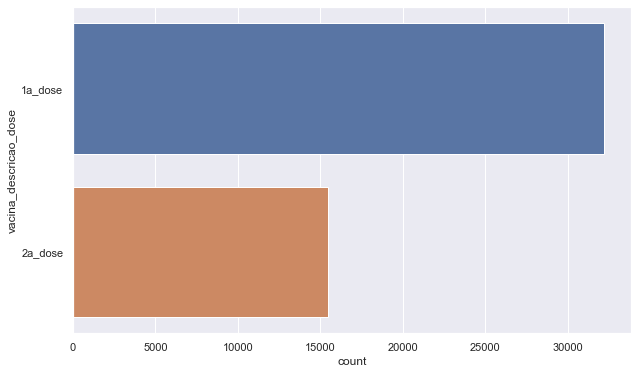

In [43]:
# Momento Antes:


plt.figure(figsize = (10,6))
sns.countplot(data = Amostra_antes, y = "vacina_descricao_dose")


In [ ]:
# Construindo o Modelo:

In [20]:

feature = 'vacina_descricao_dose'
target =  'vacina_dataAplicacao'

X_train, X_test, y_train, y_test = train_test_split(Amostra_antes[feature], pivot_test_antes[target],
                test_size = 2, random_state = 12345)

ValueError: Found input variables with inconsistent numbers of samples: [47650, 288]